<div style="background:#FFFFEE; color:#440404; padding:8px; border-radius: 4px; text-align: center; font-weight: 500;">Data Analytics for Strategic Decision Makers </div>

# Extending Analytics 


---


In [2]:
#import required libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import pandas as pd
import numpy as np
import random
import requests
import json
import re
import time


/tmp/ipykernel_3117/1975265229.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Summary from the previous data analytics

According to the results of the depth (average funding of each program) and breadth (number of projects in each program) research on government investment, the government gave different ways of effort to the development of new enterprises and professional and technical development. To encourage the development of small companies, the government approves a great number of projects in innovative programs. When it comes to the research on university expertise, the government spares no effort to invest money in every difficult project. Further research can be done to investigate their outcomes so that the government can invest more accurately and bring benefits to society. 

## Question

1. According to the result from Assignment 1 Question2, the government invest a huge amount of money in "UQ - COVID-19 Vaccine" program. How influential has this program been for society?

   
Advance Queensland program encourages innovative development and invention research programs. "UQ - COVID-19 Vaccine" was the highest funding program among them, which received $10,000,000 in April 2020. Due to the large amount of spending, it is essential to know how was the benefit brought by the program. To discuss the outcome of the program, this analysis will focus on finding the relative evidences to investigate the impact of this program on society in various aspects.  It may involve qualitative or quantitative analysis. For example: how many countries are benefited by this invention?  how many vaccines are successful? how many vaccines are released to people? Did it cause any ethical problems to specific groups? How it contributed to innovative development? 

**To search for relative evidence, this analysis report will use NMF machine learning techniques to conduct an unstructured analysis on text evidence.**

## Data Cleaning and Preparation

In [3]:
#Load data from JSON file
file_path = 'UA2-YungHsin-n11750804'
file_name = "UQ-COVID19.json"
with open(f"{file_path}/{file_name}",'r', encoding='utf-8') as fp:
    articles = json.load(fp)

print(f"Loaded {len(articles)} articles from {file_name}")

Loaded 32 articles from UQ-COVID19.json


There are 32 articles that may be related to the UQ covid-19 vaccine Program. However, it's time-consuming to go through every article to find evidence manually, and it may also cause to the neglect of the important information by accident. Therefore, selecting the relative article titles first is a good way to extract the most important article more correctly and save time. 
To do this, I selected 'UQ', 'Vaccine', 'Queensland University' as the title keywords to filter the articles which are most likely talking about this UQ covid-19 vaccine.

In [4]:
# Change the data to a dataFrame and set 'title' as the column.
terms_df = pd.DataFrame(list(articles.keys()), columns=['title'])

# Define a list of keywords
keywords = ['UQ', 'Vaccine', 'Queensland University']

# Build filter conditions to retain titles containing any keyword
condition = terms_df['title'].str.contains('|'.join(keywords), case=False)

# Update the Dataframe
filtered_df = terms_df[condition]

# Change to list to see the whole title
filtered_titles = filtered_df['title'].tolist()
# the contents of articles after filtering
filtered_contents = [articles[title] for title in filtered_titles]


filtered_titles

["University of Queensland Covid vaccine: the government's pulled the plug so what happens now? [2020-12-11T05:26:11Z]",
 '‘Stuffed’: how Australia’s ‘unconscionable’ gamble on Covid vaccines backfired [2021-07-09T20:00:03Z]',
 "Church objections to promising Covid-19 vaccine dismissed by Australia's deputy chief medical officer [2020-08-24T09:40:31Z]",
 'Australian production of non-protein Covid-19 vaccine may take an extra year, minister says [2020-10-25T01:22:30Z]',
 'From the front to the back of the queue: how Australia’s vaccine rollout unravelled [2021-07-08T17:30:25Z]',
 'Australian government announces Covid vaccine deals to provide 84.8m doses [2020-09-06T12:30:24Z]',
 'Australian government does deal to secure potential Oxford University Covid vaccine [2020-08-18T12:30:38Z]',
 'The race for a Covid vaccine: inside the Australian lab working round the clock to produce 100m doses [2020-10-10T19:00:45Z]',
 'Australia lagging on contributions to global body funding Covid vaccin

Regarding the 11 filtered titles, any of them contain the keywords 'UQ' or 'Vaccine' or'Queensland University', which makes the goal of finding evidence more closer.

Before conducting the analysis, cleaning redundant words in those article contents is important for further NMF machine learning.
For doing this, there are three methods in the cleaning step:
1. Excluding stopwords: Removing stop words (EX: "the", "and", "is", etc.), punctuations, and other irrelevant words. (Importing 'nltk' stopwords package first to define stopwords)
2. lemmatization: ChatGpt recommend the 'lemmatization' method in 'nltk'（Natural Language Toolkit). It is a process of returning word forms back to their base form, for example, 'eating' to 'eat', 'women' to 'woman'. 
3. TF-IDF: Weighting important words and reduce the impact of common but irrelevant words.
   
These cleaning methods can be helpful for building NMF model to increase the weight of meaningful keywords, which is essential for extracting evidence in articles precisely. 

**Excluding stopwords and Lemmatization**

In [5]:
#the first 100 charactors before cleaning
filtered_contents[0][:100]

'The Australian government has terminated its agreement with Australian biotech company CSL Limited t'

In [6]:
!pip install nltk

In [7]:
#import stopwords and lemmatization packages form nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [8]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/n11750804/ifn619/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/n11750804/ifn619/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
# define the funtion for removing stopwords and conducting lemmatization

def clean_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    text = re.sub(r'\W', ' ', text)  # removing non-word
    text = re.sub(r'\s+', ' ', text)  # removing space
    text = text.lower()  # change words to lower cases
    
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  #lemmatization
    
    return ' '.join(words)

In [10]:
#Apply the function to all the contents
filtered_contents = [clean_text(content) for content in filtered_contents]

In [11]:
#the first 100 charactors after cleaning
filtered_contents[0][:100]

'australian government terminated agreement australian biotech company csl limited supply 51m dos cov'

Comparing the first 100 characters before and after cleaning, it shows that all the words have changed to lowercase and there are no prepositions and possessives.

**Term Frequency / Inverse Document Frequency (TF/IDF)**

Since the number of articles is not much, it is appropriate to set 'max_df' to 0.75 or higher. This avoids excluding keywords that may appear repeatedly in most articles. 'min_df' can be set to 2, which means that only words that appear in at least 2 articles will be considered. This helps eliminate words that appear only in one article, which may be noise or not important. Even if the number of documents is small, I set a larger max_features value to include more words. Doing so can retain more information, especially some specialized words for COVID-19 vaccines, leading to analysis results that are more relevant to the topic.

In [12]:
# Set parameters appropriate to your data
vectorizer = TfidfVectorizer(max_df=0.75, min_df=2, max_features=10000, stop_words="english")
# Get the document vectors
tfidf_matrix = vectorizer.fit_transform(filtered_contents)

In [13]:
# list of feature names
feature_names = vectorizer.get_feature_names_out()
# get the vector for the first document

first_document_vector = tfidf_matrix[0].toarray()

# get the top 10 weighting index
top_indices = first_document_vector.argsort()[0][-10:][::-1]

# convert to related words
top_words = [feature_names[index] for index in top_indices]
top_words

['hiv',
 'researcher',
 'trial',
 'participant',
 'protein',
 'molecular',
 'clamp',
 'immune',
 'response',
 'unit']

The results above show the top 10 important keywords for the first article. We can see some specialized medical words, such as 'hiv', 'protein', 'immune', which indicates that TF-IDF has weighted the important words in articles. Next, NMF machine learning model can be build based on the TF-IDF keywords results to identify the topics within the articles.

## Topic modelling with Non-negative Matrix Factorisation (NMF)

Using NMF model is to categorize the articles into different topics. Doing so is to select the most important articles precisely and comprehensively. Due to the small number of articles (11), I set the number of topics to 3 to ensure that the model is interpretable and will not be overfitting. Then, after building the model, I will choose one article from each topic to do a deeper context research.

In [14]:
# Set the number of topics
num_topics = 3

# Create the model
# 'random_state =42' let the outcome stay the same for every execution
nmf_model = NMF(n_components=num_topics, max_iter=200, init='random', random_state =42, beta_loss='frobenius')

# Fit the model to the data and use it to transform the data from tf-idf
doc_topic_nmf = nmf_model.fit_transform(tfidf_matrix)

# Ensure doc_topic_matrix and filtered_titles have the same length
assert len(doc_topic_nmf) == len(filtered_titles)

topic_term_nmf = nmf_model.components_

In [15]:
# list of feature names
feature_names = vectorizer.get_feature_names_out()

# Get the topics and their terms
nmf_topic_dict = {}
for index, topic in enumerate(topic_term_nmf):
    zipped = zip(feature_names, topic)
    top_terms=dict(sorted(zipped, key = lambda t: t[1], reverse=True)[:30]) #30 highest weighting keywords
    nmf_topic_dict[f"topic_{index}"] = top_terms

In [16]:
# Create a dataframe to hold top terms and each title for the further articles searching 
terms_df = pd.DataFrame(index=filtered_titles,columns=['NMF'])
for idx,topic in enumerate(doc_topic_nmf):
    topic_num = topic.argmax()
    top_topic = nmf_topic_dict[f"topic_{topic_num}"]
    terms_df['NMF'].iloc[idx] = list(top_topic.keys())

terms_df

/tmp/ipykernel_3117/2800578007.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  terms_df['NMF'].iloc[idx] = list(top_topic.keys())


,NMF
University of Queensland Covid vaccine: the government's pulled the plug so what happens now? [2020-12-11T05:26:11Z],"[cell, protein, spike, human, hiv, line, trial..."
‘Stuffed’: how Australia’s ‘unconscionable’ gamble on Covid vaccines backfired [2021-07-09T20:00:03Z],"[pfizer, dos, rollout, march, vaccination, jul..."
Church objections to promising Covid-19 vaccine dismissed by Australia's deputy chief medical officer [2020-08-24T09:40:31Z],"[cell, protein, spike, human, hiv, line, trial..."
"Australian production of non-protein Covid-19 vaccine may take an extra year, minister says [2020-10-25T01:22:30Z]","[cell, protein, spike, human, hiv, line, trial..."
From the front to the back of the queue: how Australia’s vaccine rollout unravelled [2021-07-08T17:30:25Z],"[pfizer, dos, rollout, march, vaccination, jul..."
Australian government announces Covid vaccine deals to provide 84.8m doses [2020-09-06T12:30:24Z],"[development, contribution, funding, oxford, d..."
Australian government does deal to secure potential Oxford University Covid vaccine [2020-08-18T12:30:38Z],"[development, contribution, funding, oxford, d..."
The race for a Covid vaccine: inside the Australian lab working round the clock to produce 100m doses [2020-10-10T19:00:45Z],"[cell, protein, spike, human, hiv, line, trial..."
Australia lagging on contributions to global body funding Covid vaccine research [2020-08-13T17:30:45Z],"[development, contribution, funding, oxford, d..."
From reassurance to shambles: how Australia’s coronavirus vaccine rollout unravelled [2021-04-09T20:00:47Z],"[pfizer, dos, rollout, march, vaccination, jul..."


**NMF Visualization (Title-Topic Heatmap)**

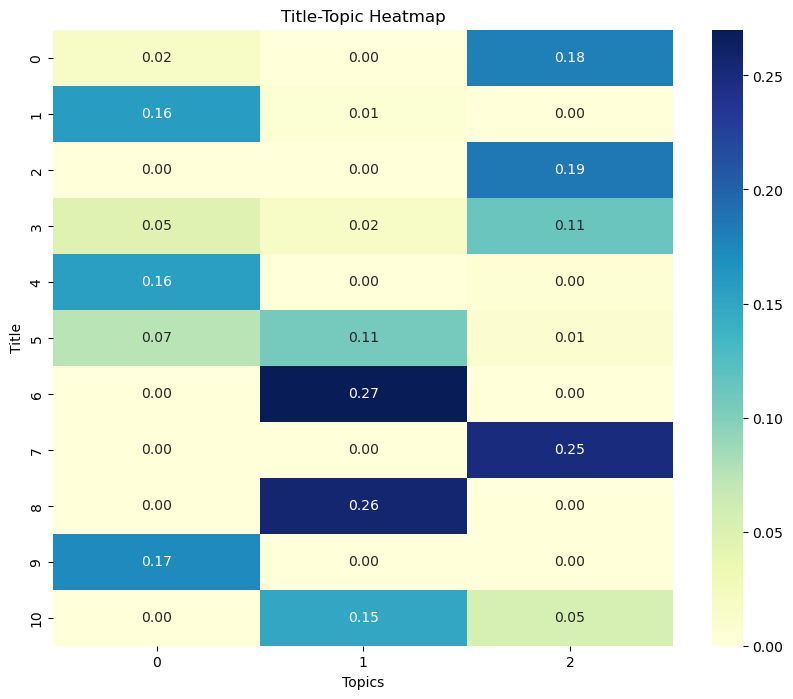

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(doc_topic_nmf, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title("Title-Topic Heatmap")
plt.xlabel("Topics")
plt.ylabel("Title")
plt.show()


The heat map shows the distribution between topics and titles. The higher the values, the more related between the title and the topic. To do comprehensive research, I chose the title with the highest correlation in each topic, which are title 9 in topic0, title 6 in topic 1 and title 7 in topic2.

## Unstructured data analysis

In [18]:
indexes = [6, 7, 9]

# print the list of titles and thier keywords
for index in indexes:
    doc = terms_df.iloc[index]
    print(f"[{index}] {doc.name}") 
    print("\t- NMF:\t\t", doc['NMF'])  
    print()


[6] Australian government does deal to secure potential Oxford University Covid vaccine [2020-08-18T12:30:38Z]
	- NMF:		 ['development', 'contribution', 'funding', 'oxford', 'discussion', 'country', 'agreement', 'commitment', 'contract', 'international', 'research', 'billion', 'global', 'sufficient', 'coalition', 'epidemic', 'support', 'distribution', 'licence', 'share', 'local', 'organisation', 'investment', 'fund', '2m', 'capacity', 'trial', 'including', 'coronavirus', 'continuing']

[7] The race for a Covid vaccine: inside the Australian lab working round the clock to produce 100m doses [2020-10-10T19:00:45Z]
	- NMF:		 ['cell', 'protein', 'spike', 'human', 'hiv', 'line', 'trial', 'immune', 'process', 'manufacturing', 'step', 'virus', 'researcher', 'nash', 'unit', 'response', 'people', 'phase', 'clamp', 'team', 'molecular', 'way', 'use', 'participant', 'andrew', 'year', 'issue', 'lot', 'letter', 'best']

[9] From reassurance to shambles: how Australia’s coronavirus vaccine rollout un

The keywords of each title represent the top terms of each topic. From the terms of the first title, it seems the discussion about the international agreement and investment of vaccine. The second one indicates some medical words such as ' immune', 'hiv' and 'trial' etc, which may be talking about the techniques of covid vaccine. The last one involves many words about numbers and months, which may describe the vaccine rollout timeline. However, it is not clear enough with these keywords. Therefore, several steps are conducted to reveal the most important context of each article.

In [19]:
selected_titles = [
    "Australian government does deal to secure potential Oxford University Covid vaccine [2020-08-18T12:30:38Z]",
    "The race for a Covid vaccine: inside the Australian lab working round the clock to produce 100m doses [2020-10-10T19:00:45Z]",
    "From reassurance to shambles: how Australia’s coronavirus vaccine rollout unravelled [2021-04-09T20:00:47Z]"
]

In [20]:
# Get the content with corresponding titles
selected_contents = [articles[title] for title in selected_titles]

Since each article is very lengthy, I asked chatgpt to teach me the methods to find sentences about 'uq', 'Queensland University', 'University of Queensland' or 'covid' from the article, including 2-3 sentences of its context and excluding duplicate sentence. This way can help me quickly find sentences related to this program.

In [21]:
def find_sentences_with_context(text, keywords, context_size=3):
    sentences = re.split(r'(?<=[.!?]) +', text)  
    keyword_indices = [i for i, sentence in enumerate(sentences) if any(keyword.lower() in sentence.lower() for keyword in keywords)]
    keyword_sentences_with_context = set()  
    
    for index in keyword_indices:
        start = max(0, index - context_size)
        end = min(len(sentences), index + context_size + 1)
        context = ' '.join(sentences[start:end])
        keyword_sentences_with_context.add(context) 
    
    return list(keyword_sentences_with_context)


initial_keywords = ['uq', 'Queensland University', 'University of Queensland']
initial_contexts = find_sentences_with_context(selected_contents[0], initial_keywords)


for context in initial_contexts:
    print(context)
    print("\n")

A statement from CSL said: “Development of the UQ vaccine candidate remains CSL’s priority, however, we are currently in discussions with AstraZeneca and the Australian government to assess whether it is possible to provide local manufacturing support for the Oxford University/AstraZeneca vaccine, should it prove successful, while protecting our commitment to the UQ vaccine. “We are assessing the viability of options ranging from the fill and finish of bulk product imported to Australia through to manufacture of the vaccine candidate under licence. There are a number of technical issues to work through and discussions are ongoing.” With the government signalling over the weekend that a deal on a vaccine was close, Labor said Morrison should increase the funding available to Australian researchers. “There absolutely should be more commonwealth funding, and $5m to the University of Queensland is not enough when you consider that the government of Queensland is putting [in] $10m,” the sha

According to the content, this article describes that Australia’s largest biotechnology company, CSL, was supporting the invention of UQ vaccine and they were discussing with governments whether it is possible to provide local manufacturing support for the other two vaccines (Oxford University/AstraZeneca). Furthermore, the Australia government says it will work to ensure the Pacific and countries in Southeast Asia have early access to a Covid vaccine.

In [22]:
def find_sentences_with_context(text, keywords, context_size=2):
    sentences = re.split(r'(?<=[.!?]) +', text)  
    keyword_indices = [i for i, sentence in enumerate(sentences) if any(keyword.lower() in sentence.lower() for keyword in keywords)]
    keyword_sentences_with_context = set() 
    
    for index in keyword_indices:
        start = max(0, index - context_size)
        end = min(len(sentences), index + context_size + 1)
        context = ' '.join(sentences[start:end])
        keyword_sentences_with_context.add(context)  
    
    return list(keyword_sentences_with_context) 

#
initial_keywords = ['uq', 'Queensland University', 'University of Queensland']
initial_contexts = find_sentences_with_context(selected_contents[1], initial_keywords)

# search 'covid-19' from the initial_contexts to make the result precise
final_keywords = ['covid-19']
final_contexts = set()  #
for context in initial_contexts:
    more_contexts = find_sentences_with_context(context, final_keywords)
    final_contexts.update(more_contexts)  

for context in final_contexts:
    print(context)
    print("\n")

The result? A broth that, once purified and combined with an immune booster, could help end the Covid-19 crisis as we know it. For months, much hope has rested on the vaccine technology developed by the University of Queensland, which has produced a version of the virus unable to use its crown – or corona – of spikes to attach to target cells inside the human body. But if hopes are realised and the UQ vaccine is found to be safe and effective, what next?


“Ultimately you have to scale up the growth of those [Chinese hamster ovary] cells to a very large volume so you can produce sufficient quantities,” CSL’s chief scientist, Andrew Nash, explains. “So in our case you end up in a 2,000L bioreactor.”   Related: Will a vaccine or recovery from the virus give us long-term immunity to Covid-19? The cells grow continuously for about 12 days, all the while producing the spike protein so crucial to the UQ vaccine. Once the 2,000L reactor is full, it is harvested and purified.


UQ has effectiv

This paragraph describes the production process and technical features of the UQ Covid-19 vaccine. UQ vaccine is a recombinant protein vaccine that uses innovative "clamping" technology on the spike proteins produced by CSL. This method induces immune responses without actual infection. The content also indicates that it is an extremely large scale and is estimated to be able to produce 100 million doses of a COVID-19 vaccine by the end of next year. 

In [23]:
def find_sentences_with_context(text, keywords, context_size=3):
    sentences = re.split(r'(?<=[.!?]) +', text) 
    keyword_indices = [i for i, sentence in enumerate(sentences) if any(keyword.lower() in sentence.lower() for keyword in keywords)]
    keyword_sentences_with_context = set()  
    
    for index in keyword_indices:
        start = max(0, index - context_size)
        end = min(len(sentences), index + context_size + 1)
        context = ' '.join(sentences[start:end])
        keyword_sentences_with_context.add(context)  
    
    return list(keyword_sentences_with_context)


initial_keywords = ['uq', 'Queensland University', 'University of Queensland']
initial_contexts = find_sentences_with_context(selected_contents[2], initial_keywords)


for context in initial_contexts:
    print(context)
    print("\n")




Australia would also gain access to 25.5m doses of a successful vaccine candidate through the Covax facility – a global initiative to support research, development and production of vaccines. 
November 
5 November: The government announces it will purchase a further 50m doses of two other vaccines, contingent on their formulas being proved safe and effective – 40m from Novavax and 10m doses from Pfizer. 
Morrison says: “We aren’t putting all our eggs in one basket and we will continue to pursue further vaccines should our medical experts recommend them.” 
December 
2 December: The British regulator rules the the Pfizer vaccine is safe for use, and by 8 December, the UK administers the first post-trial dose of the Pfizer vaccine in the world. 
11 December: The UQ trials are abandoned after participants returned false positive test results for HIV, and the government terminates its agreement for the 51m doses it had ordered. 
As a result, Australia plans to increase its reliance on the 

The context above shows the information about vaccine resources. It mentioned that the government had an intention to buy 51m doses of UQ vaccine, however, the UQ vaccine trials were abandoned after participants returned false positive test results for HIV, so the agreement for the 51m doses has been terminated.

## Insight

According to the contexts above, 'UQ Covid-19 Vaccine' program was one of Australia's important projects, which promoted the development of innovative scientific technologies. It was initially very promising, using an innovative "clamping" technology on the spike proteins to induce an immune response. However, major setbacks were encountered during the first clinical trial, participants developed false-positive HIV results, leading to the abandonment of the vaccine trial. Therefore, this program was not successful in the end and the vaccines were not released to the public. Although the government had the intention to purchase 51m doses of vaccines and neighboring Pacific and Southeast Asian countries might be benefited from the invention, its failure in clinical trials terminated the agreement and the subsequent trials. Therefore, it did not cause direct benefit to the international community's vaccination. However, the experimental process has had some impact on society in some aspects.
1. Contribution to Innovative Development:
Despite its failure to reach the market, the UQ vaccine contributed to vaccine innovation by exploring a new approach of clamping technology for leading immune responses without actual infection. It provides valuable insights for future vaccine development projects.
2. Ethical influence:
The false-positive HIV results among participants during the clinical trial have caused serious ethical concerns. This issue not only raised ethical considerations regarding the safety and reliability of the experiment but also affected public trust in vaccine production processes, potentially influencing vaccine development. This led to the termination of the later stages.
5. Collaboration between industry and academic research:
The collaboration of UQ and biotechnology company, CSL promoted communication of scientific research between industry and academia. It is crucial for the innovation of professional techniques and the large-scale production of innovative

Due to the confidentiality of experiments and limited public resources, it's difficult to find quantitative data for analysis. However, from the articles in the Guardian website, some evidence still proved the qualitative impact on society. In conclusion, the program did not succeed as expected, but the process is still meaningful and valuable to the development of innovative technology. 